# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices

# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]
                
                

# problematic_subjects_fraudulent =["66bb5c09526e6d80f1146800"]
                # This subject had "eclectic performances" so say the least
                # Left fullscreen twice and missed 4 actions


# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")


 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


## 1. Dataset composition
A few plots to show how the participants demographics compared.

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175]
0      20.0
1      27.0
2      22.0
3      29.0
4      29.0
       ... 
140   

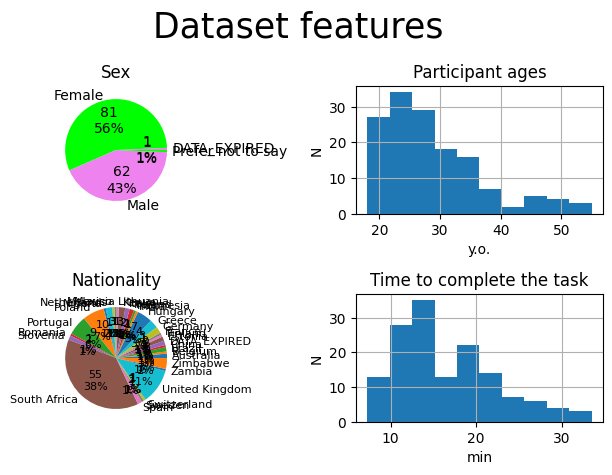

In [4]:
# Create a pandas dataframe from the list of subject dictionnaries :
list_of_feedback_noise_intensities = [entry[2]["parameters"]["noise_int"][0] for entry in TASK_RESULTS]
        # The noise is the same across all trials in task 002
print(list_of_feedback_noise_intensities)

list_of_dicts = [entry[0] for entry in TASK_RESULTS]
subjects_df = pd.DataFrame(list_of_dicts)


print(subjects_df["Age"])
print(subjects_df.loc[(subjects_df["Age"] == "CONSENT_REVOKED")])


# Add the noise parameter data : 
subjects_df.insert(0, "feedback_noise_intensity", list_of_feedback_noise_intensities, True)
# Add the time taken recorded by the application : (a better measure than the one provided by Prolific for some reason)
subjects_df["application_measured_timetaken"] = (subjects_df["finish_date"]-subjects_df["start_date"]).dt.total_seconds()

fig, axs = plt.subplots(2, 2, dpi=100, tight_layout=True)
fig.suptitle("Dataset features",fontsize=25)
ax_sex = axs[0,0]
ax_age = axs[0,1]
ax_country = axs[1,0]
ax_time_to_complete_task = axs[1,1]


ax_sex.set_title("Sex")
def label_function(val):
    return f'{val / 100 * len(subjects_df):.0f}\n{val:.0f}%'
subjects_df.groupby('Sex').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['violet', 'lime'], ax=ax_sex)

ax_age.set_title("Participant ages")
ax_age.hist(subjects_df["Age"],bins=10)
ax_age.set_xlabel("y.o.")
ax_age.set_ylabel("N")
ax_age.grid()    

ax_country.set_title("Nationality")
subjects_df.groupby('Nationality').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, ax=ax_country)

ax_time_to_complete_task.set_title("Time to complete the task")
ax_time_to_complete_task.hist(subjects_df["application_measured_timetaken"]/60,bins=10)
ax_time_to_complete_task.set_xlabel("min")
ax_time_to_complete_task.set_ylabel("N")
ax_time_to_complete_task.grid()    

print('Browser check : ')
print(subjects_df["browser"])


<Axes: xlabel='Count', ylabel='feedback_noise_intensity'>

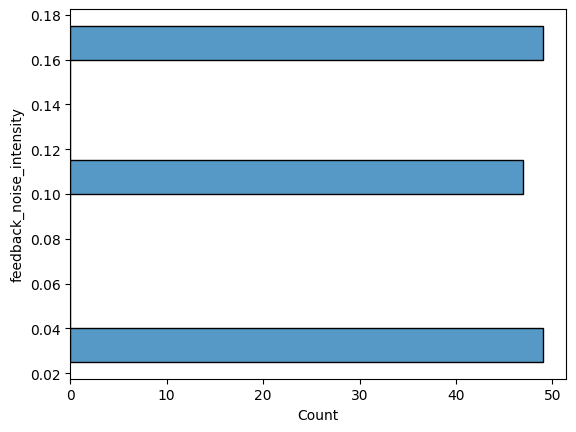

In [10]:
sns.histplot(data=subjects_df, y="feedback_noise_intensity",bins=10,kde=False)

## 2. Analyzing the results !

Let's start by the feedback trajectories :

In [19]:
# Training curves : 
all_feedback_data = np.stack([subjdata[2]["scoring"]["feedback"] for subjdata in TASK_RESULTS])
true_feedback_all_subjects = np.stack([subjdata[2]["scoring"]["feedback"].flatten() for subjdata in TASK_RESULTS])

Nsubj = all_feedback_data.shape[0]
all_timesteps = np.arange(true_feedback_all_subjects.shape[-1])
one_trial_timesteps = np.arange(all_feedback_data.shape[-1])

# First and last K trials : 
K = 5
mean_first_K,std_first_K = np.mean(all_feedback_data[...,:K,:],axis=1),np.std(all_feedback_data[...,:K,:],axis=1)
mean_last_K,std_last_K = np.mean(all_feedback_data[...,-K-1:-1,:],axis=1),np.std(all_feedback_data[...,-K-1:-1,:],axis=1)

colorlist = np.random.random((Nsubj,3))
# Figures  _______________________________________________________________________________________________________
fig,ax = plt.subplots()
fig.suptitle("True feedback level across trials for all subjects")
mean_fbs = np.mean(true_feedback_all_subjects,axis=0)
std_fbs = np.std(true_feedback_all_subjects,axis=0)  # Std between all subjects
ax.plot(all_timesteps,mean_fbs)
ax.fill_between(all_timesteps,mean_fbs - std_fbs, mean_fbs + std_fbs, alpha = 0.2)
ax.set_ylabel("True feedback level")
ax.set_xlabel("Timesteps")
# ax.axvline(np.linspace(0,timesteps[-1],11))
ax.grid()


# Comparing the first K and the last K trials : 
fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
fig.suptitle("Average trial true feedback for each subjects",y=1.05)
for ax in axs :
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel("Timestep")
    ax.grid()
axs[0].set_ylabel("True feedback level")
axs[0].set_title("First " + str(K) + " trials.") 
axs[1].set_title("Last " + str(K) + " trials.") 
for subject_data in range(mean_first_K.shape[0]):
    color = colorlist[subject_data,:]

    axs[0].plot(one_trial_timesteps,mean_first_K[subject_data,...],color=color,alpha=1,label = str(subject_data))
    # axs[0].fill_between(one_trial_timesteps,mean_first_K[subject_data,...] - std_first_K[subject_data,...], mean_first_K[subject_data,...] + std_first_K[subject_data,...],color=color, alpha = 0.2)
    
    axs[1].plot(one_trial_timesteps,mean_last_K[subject_data,...],color=color,alpha=1)
    # axs[1].fill_between(one_trial_timesteps,mean_last_K[subject_data,...] - std_last_K[subject_data,...], mean_last_K[subject_data,...] + std_last_K[subject_data,...],color=color, alpha = 0.2)
# fig.legend()
fig.show()

# Same plot but for each subject individually :
# Comparing the first K and the last K trials : 
Ncols = 10
Nlines = Nsubj//Ncols
if (Nlines - Nsubj/Ncols)>0.01:
    Nlines = Nlines + 1

fig,axs = plt.subplots(Nlines,Ncols,sharey=True,sharex=True,dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})#,figsize = (2*Nsubj,3))
fig.suptitle("Average trial true feedback for each subject",y=1.05)
for ax in axs.reshape(-1):
    ax.set_ylim([0.0,1.0])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=5)
    ax.grid()
    
    # a.set_xticklabels([])
    # a.set_yticklabels([])
    # ax.set_aspect('equal')


all_feedback_data = np.stack([subjdata[2]["scoring"]["feedback"] for subjdata in TASK_RESULTS])
one_trial_timesteps = np.arange(all_feedback_data.shape[-1])

for line in range(Nlines):    
    for col in range(Ncols):
        ax = axs[line,col]
        
        subj_n = line*Ncols + col
        if subj_n < Nsubj:
            # ax.set_title("Subject " + str(subj_n))
            color = colorlist[subject_data,:]
            ax.plot(one_trial_timesteps,mean_first_K[subj_n,...],color="blue",alpha=1,label="first " + str(K) + " trials"if subj_n == 0 else "")
            ax.plot(one_trial_timesteps,mean_last_K[subj_n,...],color="red",alpha=1,label="last " + str(K) + " trials"if subj_n == 0 else "")
            
            ax.fill_between(one_trial_timesteps,mean_first_K[subj_n,...] - std_first_K[subj_n,...], mean_first_K[subj_n,...]+ std_first_K[subj_n,...],color="blue", alpha = 0.3)
            ax.fill_between(one_trial_timesteps,mean_last_K[subj_n,...] - std_last_K[subj_n,...], mean_last_K[subj_n,...] +std_last_K[subj_n,...],color="red", alpha = 0.3)   
                
# axs[0].set_title("First " + str(K) + " trials.") 
# axs[1].set_title("Last " + str(K) + " trials.") 
axs[-1,Ncols//2].set_xlabel("Timestep")
axs[Nlines//2,0].set_ylabel("True feedback level")
# fig.subplots_adjust(wspace=0, hspace=0)
fig.legend(["First " + str(K) + " trials","Last " + str(K) + " trials"],bbox_to_anchor=(0.75, 1.0), ncol=2)
fig.tight_layout()


# Same plot, but mean across subjects : 
# Comparing the first K and the last K trials : 
fig,ax = plt.subplots(1,1,figsize=(4,3))
fig.suptitle("True feedback level across trials for all subjects")
ax.set_ylim([0.0,1.0])
ax.set_xlabel("Timestep")
ax.set_ylabel("True feedback level")
ax.grid()

mean_first_K,std_first_K = np.mean(all_feedback_data[...,:K,:],axis=(0,1)),np.std(all_feedback_data[...,:K,:],axis=(0,1))
mean_last_K,std_last_K = np.mean(all_feedback_data[...,-K:,:],axis=(0,1)),np.std(all_feedback_data[...,-K:,:],axis=(0,1))

ax.plot(one_trial_timesteps,mean_first_K,color="blue",alpha=1,label="first " + str(K) + " trials")
ax.fill_between(one_trial_timesteps,mean_first_K - std_first_K, mean_first_K+ std_first_K,color="blue", alpha = 0.3)

ax.plot(one_trial_timesteps,mean_last_K,color="red",alpha=1,label="last " + str(K) + " trials")
ax.fill_between(one_trial_timesteps,mean_last_K - std_last_K, mean_last_K +std_last_K,color="red", alpha = 0.3)
    
ax.legend()

Judging by the curves, it appears we encounter 4 broad types of subjects :
- Subjects who start the training with poor performances yet learn the correct transition rule and reach very good performances
- Subjects with nice performances from the get go, but who struggle to get better
- Subject who struggle to make sense of the feedback and don't improve
- Subjects with nice performances from the get go

Let's focus on subject actions :

We may consider that each couple of point is the result of a weighted composition of action model hypotheses. To be clearer, each couple of point can be seen as the realization of one (or several) specific beliefs about how the feedback is controlled. One possible composition of hypotheses is :
- (H1) - The feedback may answer to where (on the grey screen) is the baricenter of the points I dropped
- (H2) - The feedback may answer to how far from one another the points are
- (H3) - The feedback may answer to where the second point is relative to the first
- (H4) - The feedback may answer to temporal elements, such as how quickly the action is performed or based on the dynamics of the gauge

Let's transform the point coordinates to fit each of those hypotheses : 

(145, 11, 10)
(11, 10)


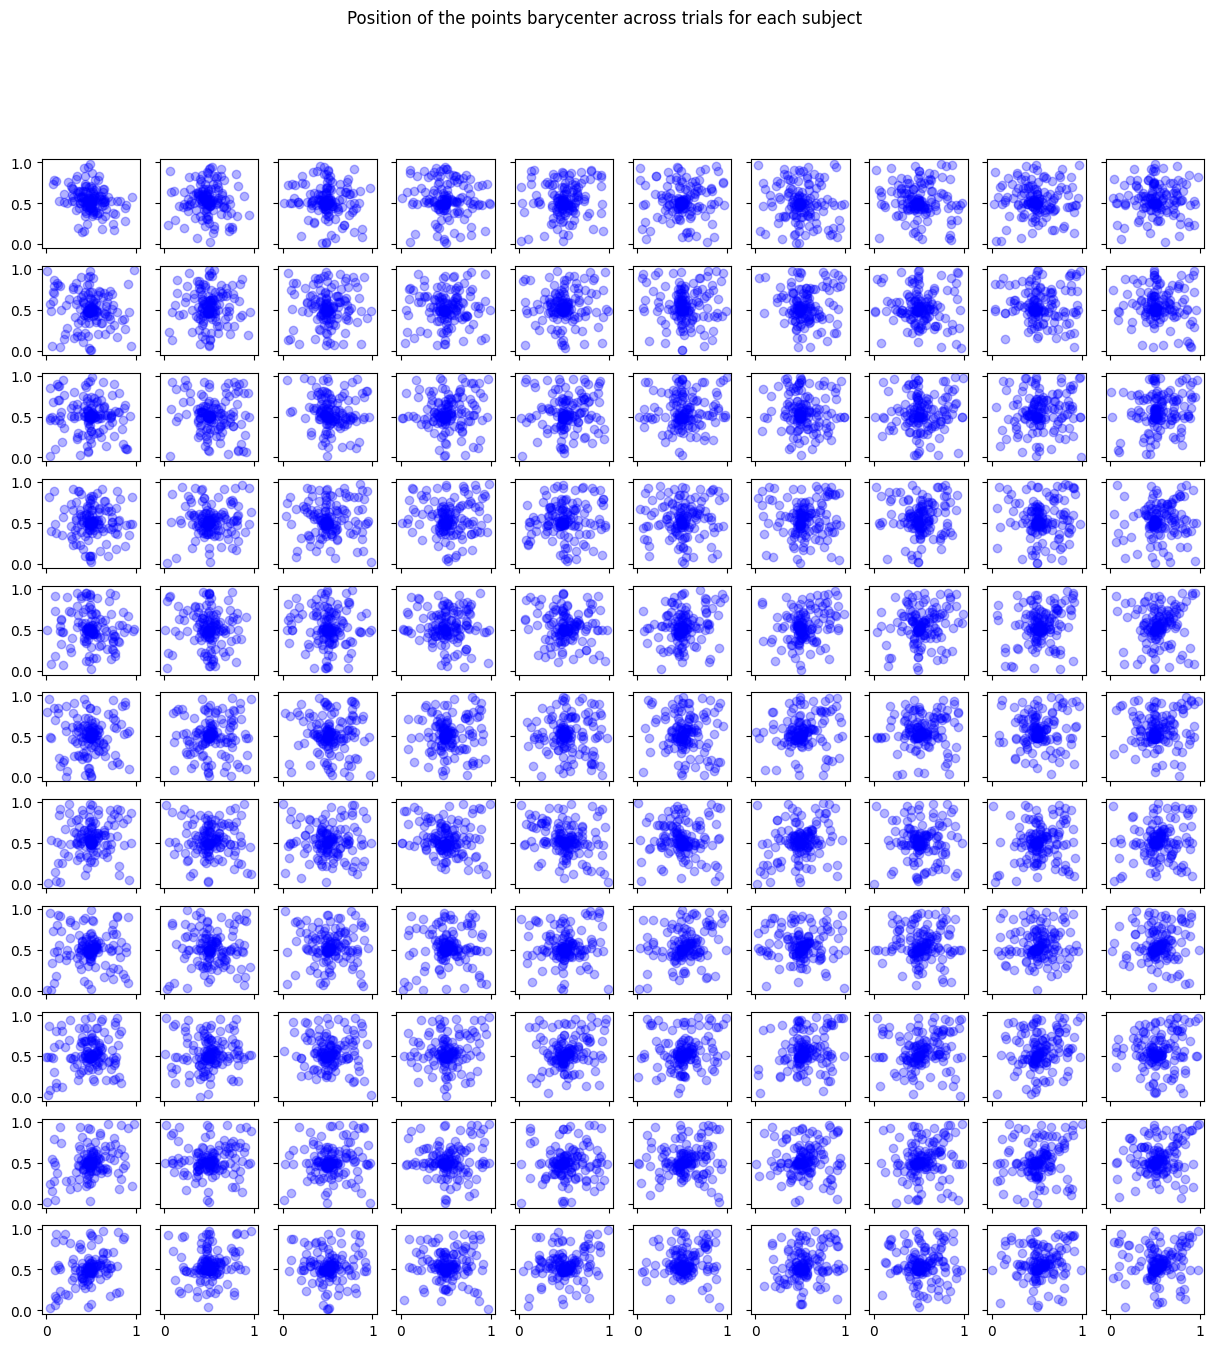

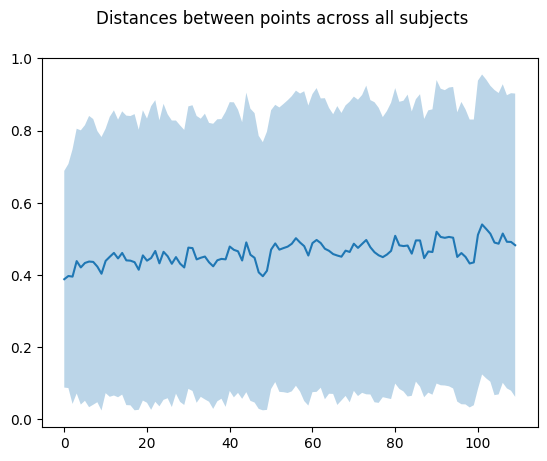

In [11]:
# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"]
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]
#___________________________________________________________________________________


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

first_point_weights = all_actions_data[...,0,-1]
second_point_weights = all_actions_data[...,1,-1]

# First, let's get the position of the barycenter for all actions. 
barycenter_x = (all_actions_data[...,0,0]*first_point_weights+all_actions_data[...,1,0]*second_point_weights)/(first_point_weights+second_point_weights+1e-10)
barycenter_y = (all_actions_data[...,0,1]*first_point_weights+all_actions_data[...,1,1]*second_point_weights)/(first_point_weights+second_point_weights+1e-10)
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)


# # Plot barycenter trajectories for each subject : 
fig,axes = plt.subplots(Ntrials,Nactions,sharex=True,sharey=True,figsize=(15,15))
fig.suptitle("Position of the points barycenter across trials for each subject")
for trial in range(Ntrials):
    for t in range(Nactions):
        ax = axes[trial,t]
        
        reduced_barycenter_list = barycenters[:,trial,t,...][both_points_only[:,trial,t]]
        ax.scatter(reduced_barycenter_list[:,0],reduced_barycenter_list[:,1],color="blue",alpha=0.3)

# Then, let's get the distance of both points for all actions. 
distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
# Missed actions should count as distance = 0:


distances_nan = np.where(both_points_only,distances,np.nan)
print(distances_nan.shape)
# Mean for all subjects : 
mean_subjects_nan = np.nanmean(distances_nan,axis=0)
std_subjects_nan = np.nanstd(distances_nan,axis=0)
print(mean_subjects_nan.shape)

mean_flat = mean_subjects_nan.flatten()
std_flat = std_subjects_nan.flatten()
# distances[~both_points_only] = 0.0


# # # Flatten this for each subject as we want to see the curve across all trials :

# # fig,ax = plt.subplots(Nsubj,1,sharey=True)
# # fig.suptitle("Distances between points for each subject")
# # for subj in range(Nsubj):    
# #     ax[subj].scatter(np.arange(distances_flat.shape[1]),distances_flat[subj,:])
    
# # Plot evolution of distances across trials for each subject : 
fig,ax = plt.subplots(1)
fig.suptitle("Distances between points across all subjects")
dist_mean = np.mean(mean_subjects_nan,axis=0)
dist_std = np.std(std_subjects_nan,axis=0)
ax.plot(np.arange(mean_flat.shape[0]),mean_flat)#,alpha = all_actions_data[subj,trial,:,1,-1])
ax.fill_between(np.arange(mean_flat.shape[0]),mean_flat-std_flat,mean_flat+std_flat,alpha=0.3)

The cuerve is very bizarre, but it can be explained by the task design : subjects who managed to control the feecback ended the trials early, whereas the others did not. Thus, around the middle of each task (the optimal time to end the trial), the successful subjects drop from the graph, leading only the subjects who struggle, causing this almost periodic pattern. We should plot the same graph but differentiating those who managed to finish their trials from those who did not.

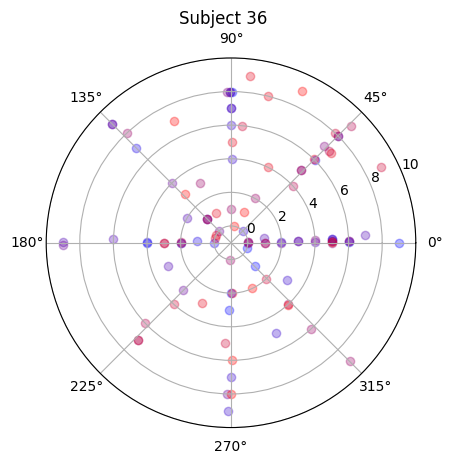

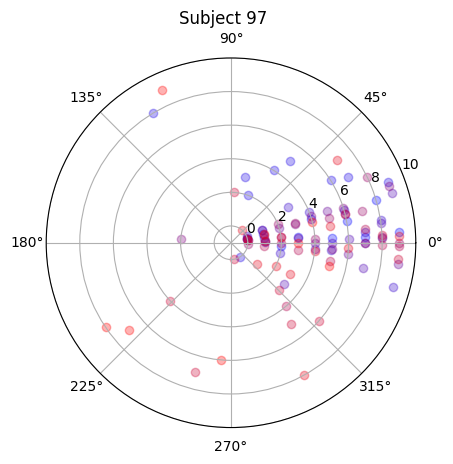

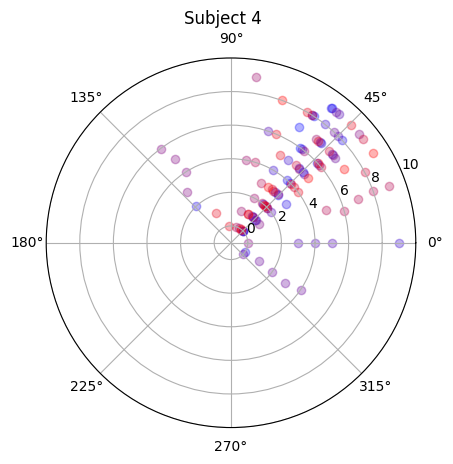

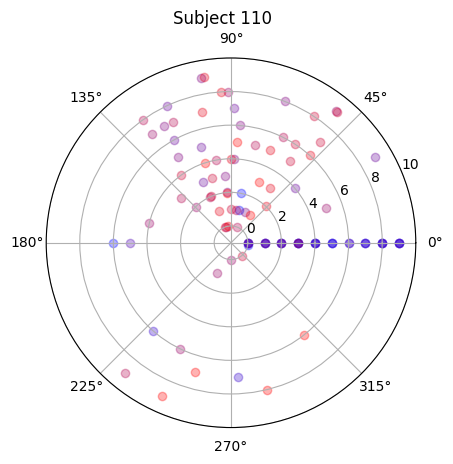

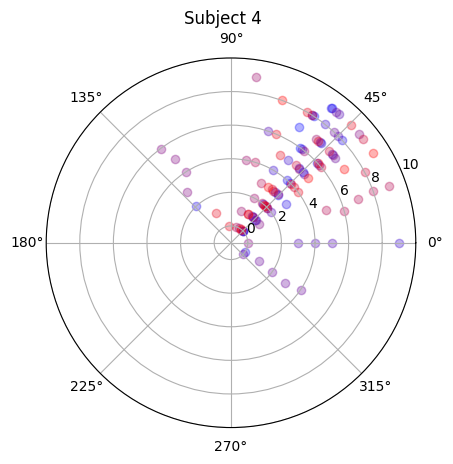

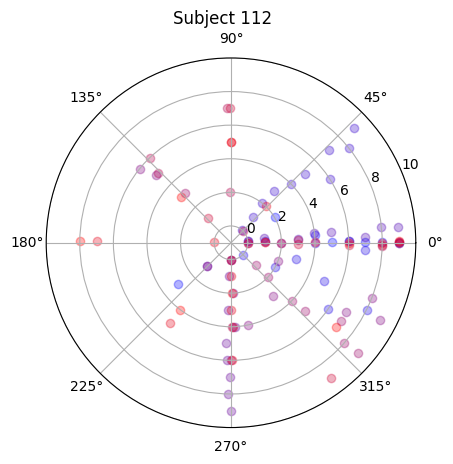

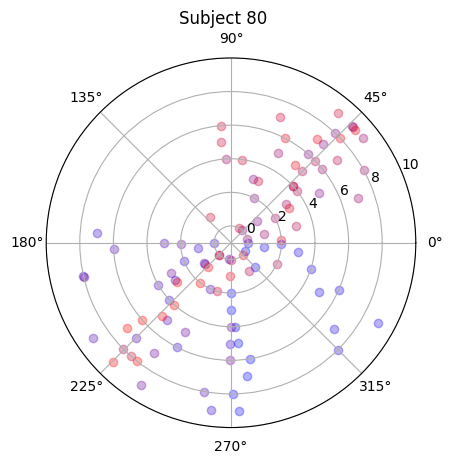

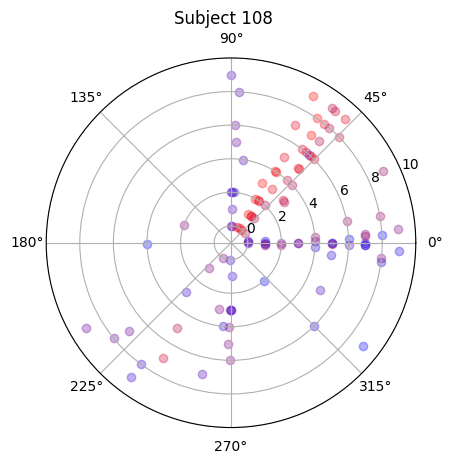

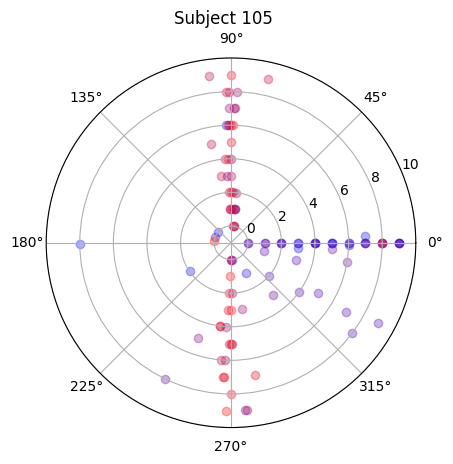

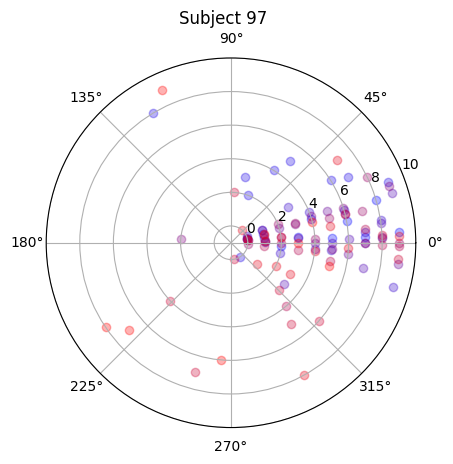

In [12]:
colors = np.linspace(np.array([0.0,0.0,1.0,1.0]),np.array([1.0,0.0,0.0,1.0]),Ntrials)


# Plot evolution of angles
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
angles_flat = angles.reshape((Nsubj,-1))


# # Figure with all the angles :
# fig,ax = plt.subplots(Nsubj,1,sharey=True)
# fig.suptitle("Angle between points for each subject")
# for subj in range(Nsubj):    
#     ax[subj].scatter(np.arange(angles_flat.shape[1]),angles_flat[subj,:])
    
for subj in np.random.choice(Nsubj,10):
    fig = plt.figure()# plt.subplots(projection='polar')
    ax = fig.add_subplot(111,projection='polar')
    
    
    for trial in range(Ntrials):
        trial_vals = angles[subj,trial]
        ax.scatter(trial_vals,np.arange(trial_vals.shape[0]),color=colors[trial],alpha=0.3)
    
    ax.set_ylim(bottom  = -1,top = trial_vals.shape[0])
    fig.suptitle("Subject " + str(subj))

In [13]:
# This is still a bit hard to read, let's plot an alternative figure ! 
# Idea : polar histogram showing counts of actions performed by the subjects, with 
# each action given a specific color : 
# array of angles, between -pi and pi
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
print(angles.shape)  # Nsubjects x Ntrials x Nactions

N_bin_categories = 32 # A multiple of 4 (or 8 !)

# The middle of the cardinal points should be the center of their respective bins
half_a_bin = (2*np.pi/(N_bin_categories))*0.5
bins = np.linspace(-np.pi + half_a_bin,np.pi - half_a_bin,N_bin_categories) 

digitized_angles = np.zeros_like(angles)
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        digitized_angles[subject,trial,:] = np.digitize(angles[subject,trial,:],bins)   
digitized_angles[digitized_angles > N_bin_categories-1] = 0
digitized_angles = digitized_angles.astype(int)

angle_counts = np.zeros((Nsubj,Ntrials,N_bin_categories))
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        angle_counts[subject,trial,:] = np.bincount(digitized_angles[subject,trial,:],minlength=N_bin_categories)

# Let's transform it into a pandas dataframe with 4 coordinates ! 
def using_multiindex(_array, columns):
    shape = _array.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'Value': _array.flatten()}, index=index).reset_index()
    return df
df_digit_angles = using_multiindex(digitized_angles, ["Subject","Trial","Timestep"])
df_anglecounts = using_multiindex(angle_counts, ["Subject","Trial","Angle"])




# Plot the angles for each specific subject !
def get_fig_for_subject(subj_id,size=800):
    subject_anglecounts = df_anglecounts.loc[df_anglecounts["Subject"]==subj_id][["Trial", "Angle", "Value"]]
    subject_anglecounts["Angle_degrees"] = (subject_anglecounts["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(subject_anglecounts, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = subject_anglecounts.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=False)
    
    # fig.update_layout(
    #     margin={'t':0,'l':0,'b':0,'r':0}
    # )
    
    # fig.update_layout(legend=dict(
    #     orientation="v",
    #     yanchor="top",
    #     y=-0.1,
    #     xanchor="center",
    #     x=0.5),
    # )
    return fig


# Plot the angles for each specific subject !
def get_fig_for_all_subjects(size=800,showlegend=True):
    total_anglecounts = df_anglecounts.groupby(["Trial","Angle"])["Value"].sum()
    # total_anglecounts["Total"] = total_anglecounts["Value"].sum()
    total_anglecounts_df = total_anglecounts.reset_index()
    
    total_anglecounts_df["Angle_degrees"] = (total_anglecounts_df["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(total_anglecounts_df, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = total_anglecounts_df.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=showlegend)
    
    # fig.update_layout(
    #     margin={'t':0,'l':0,'b':0,'r':0}
    # )
    
    # fig.update_layout(legend=dict(
    #     orientation="v",
    #     yanchor="top",
    #     y=-0.1,
    #     xanchor="center",
    #     x=0.5),
    # )
    return fig

my_figure = get_fig_for_subject(0,600)
my_figure.show()

my_figure = get_fig_for_subject(1,600)
my_figure.show()


all_subjects_figure = get_fig_for_all_subjects()
all_subjects_figure.show()

(145, 11, 10)


In [14]:
# Plot the angles for all subjects !
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

figures = [get_fig_for_subject(k) for k in range(Nsubj)]


NROWS = 2
NCOLS = 5
fig = make_subplots(rows=NROWS, cols=NCOLS, specs=[[{'type': 'polar'}]*NCOLS]*NROWS,
                    horizontal_spacing = 0.0,vertical_spacing=0.1) 

for row in range(NROWS):
    for col in range(NCOLS):
        subj_id = row*NCOLS + col
        
        figure = figures[subj_id]
        for trace in range(len(figure["data"])):
            
            polar_update=dict(
                radialaxis = dict(
                    range=figure.layout["polar"]["radialaxis"]["range"]
                )
            )
            
            fig.append_trace(figure["data"][trace], row=row+1, col=col+1)
            fig.update_polars(polar_update,row=row+1,col=col+1)
            # fig.update_yaxes(range=xrange,row=row+1,col=col+1)
fig.update_layout(width=2000, height=600)
        
fig.update_layout(
        margin={'t':20,'l':0,'b':20,'r':0}
    )

fig.show()


## 3. Basic modelling : correlation between variables, statistical tests ...

C:\Users\annic\AppData\Local\Temp\ipykernel_39036\2062502119.py:47: UserWarning:


The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.

C:\Users\annic\AppData\Local\Temp\ipykernel_39036\2062502119.py:49: UserWarning:


The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.



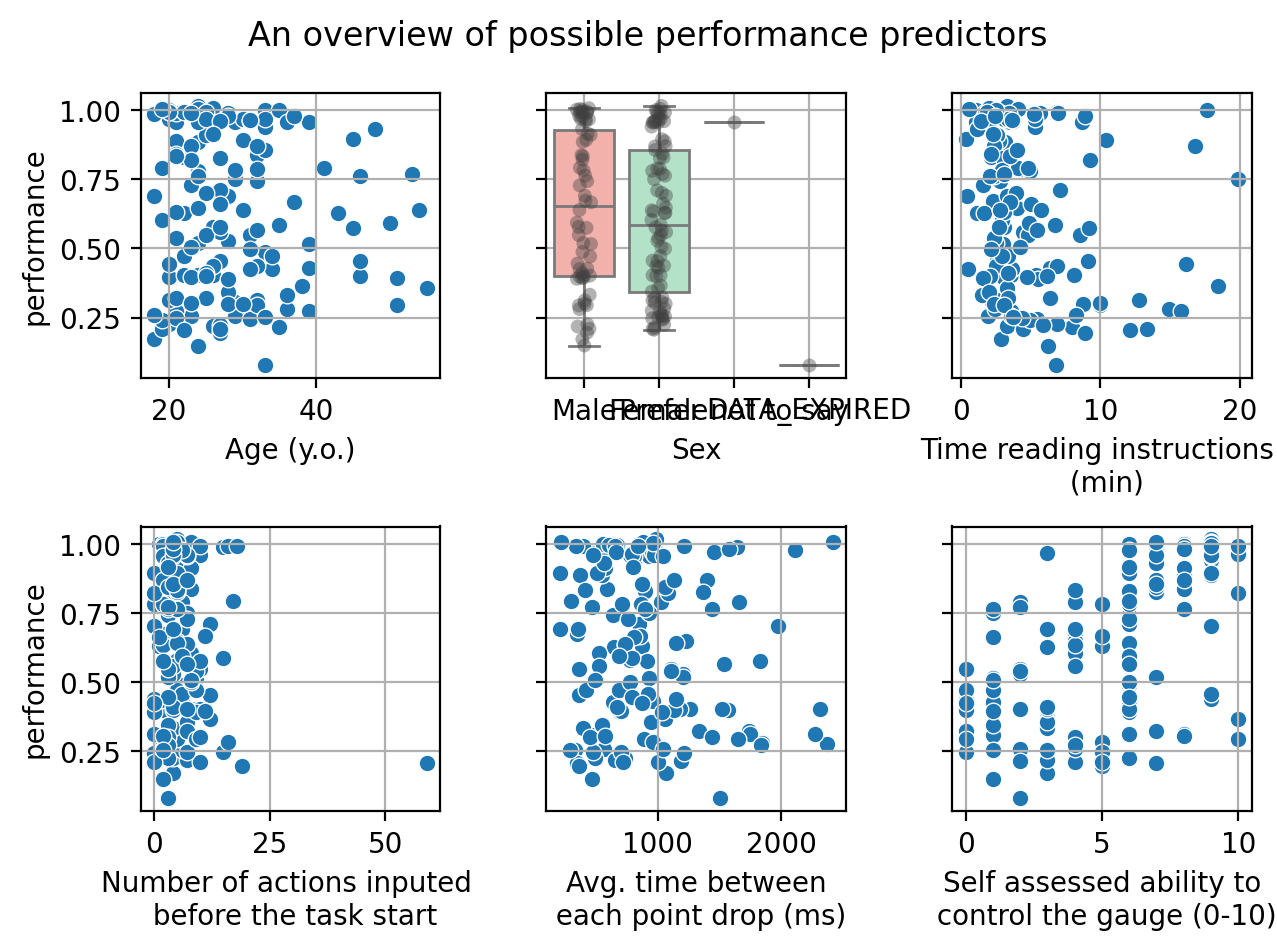

In [15]:
# Plot Age (regression), sex (histogram), time spent reading instructions (regression), number of points drawn (histogram) and average time before action (regression) vs performances of the subjects :

# First, let's get the values of interest for our subjects : 
# 1. The average (true) feedback level (over the whole training)
# 2. The average (true) feedback level (during the last K trials)

task_data = [subj_task_results[2] for subj_task_results in TASK_RESULTS] # Only get task data

# Exploring the recorded data !
# task_data_subject_0 = task_data[0]
# # We have access to trial-scale data :
# print(task_data_subject_0["scoring"]["scores"])
# print(task_data_subject_0["scoring"]["success"])
# # And timestep scale data :
# print(task_data_subject_0["scoring"]["feedback"])

feedback_for_all_subjects = np.stack([subj_data["scoring"]["feedback"] for subj_data in task_data])
# print(feedback_for_all_subjects.shape)


# What window of feedback(i.e. distance) values allows us to characterize the perofrmance of subject ?
last_k_trials = 4
last_t_timesteps = 5
feedback_all_subjs_window = feedback_for_all_subjects[:,-last_k_trials-1:-1,-last_t_timesteps:]
    # The very last trial was without a gauge, it does not count :p
mean_feedback_all_subjs_last_k_trials = np.mean(feedback_all_subjs_window,axis=(-1,-2))
performance_metric = mean_feedback_all_subjs_last_k_trials

# Create a pandas dataframe from the list of subject dictionnaries :
subjects_df["performance"] = performance_metric.tolist()


# Get subject personnal data !
fig,axes = plt.subplots(2,3,sharey=True,dpi=200)
fig.suptitle("An overview of possible performance predictors")

# 1. Ages !
ax1 = axes[0,0]
sns.scatterplot(ax=ax1, data=subjects_df,
                x="Age", y="performance")
ax1.set_xlabel("Age (y.o.)")
ax1.grid()

# 2. Sexes !
sexes = [subj_task_results[0]["Sex"] for subj_task_results in TASK_RESULTS]
ax2 = axes[0,1]
sns.boxplot(ax = ax2, x="Sex", y="performance", hue="Sex",
                data=subjects_df,palette=["#FFA7A0", "#ABEAC9"],dodge=False)
sns.stripplot(ax=ax2 , x="Sex", y="performance", 
                hue="Sex",data=subjects_df,palette=["#404040","#404040"], 
                alpha=0.4, dodge=False)
ax2.grid()

# 3. Time spent reading the instructions 
ax3 = axes[0,2]

instr_all_subj = [subj_task_results[1]["instructions"] for subj_task_results in TASK_RESULTS]
t_starts = [[evt["t"] for evt in instr if evt["val"]=="start_instructions" ] for instr in instr_all_subj]
t_ends = [[evt["t"] for evt in instr if evt["val"]=="end_instructions" ] for instr in instr_all_subj]
delta_ts = [(end[0]-start[0])/(60*1000.0) for (end,start) in zip(t_ends,t_starts)]
subjects_df["TimeReadingInstructions"] = delta_ts
sns.scatterplot(ax=ax3, data=subjects_df,
                x="TimeReadingInstructions", y="performance")
ax3.grid()
ax3.set_xlabel("Time reading instructions \n (min)")

# 4. Numver of points dropped on the trial action screen
ax4 = axes[1,0]
subjects_df["N_actions_tested"] = [len(try_points) for try_points in subjects_df["canvas_explore_points"].values]
sns.scatterplot(ax=ax4, data=subjects_df,
                x="N_actions_tested", y="performance")
ax4.grid()
ax4.set_xlabel("Number of actions inputed \n before the task start")

# 5. Average time between the two points !
ax5 = axes[1,1]

actions_for_all_subjects = np.stack([subj_data["blanket"]["actions"] for subj_data in task_data])
all_action_delays = actions_for_all_subjects[...,-1,2]
unfit_actions = (all_action_delays<10)
mean_of_action_delays_for_each_subjects = np.nanmean(np.where(all_action_delays>10, all_action_delays, np.nan), axis=(-1,-2))
subjects_df["Time_between_points"] = mean_of_action_delays_for_each_subjects.tolist()
sns.scatterplot(ax=ax5, data=subjects_df,
                x="Time_between_points", y="performance")
ax5.set_xlabel("Avg. time between\n each point drop (ms)")
ax5.grid()

# 6. Self assessment at the end of the task
ax6 = axes[1,2]
sns.scatterplot(ax=ax6, data=subjects_df,
                x="mandatory_q1", y="performance")
ax6.set_xlabel("Self assessed ability to\n control the gauge (0-10)")
ax6.grid()

fig.tight_layout()






Let's now explore the effect of the feedback noise on our performance metric ! 

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning:

invalid value encount

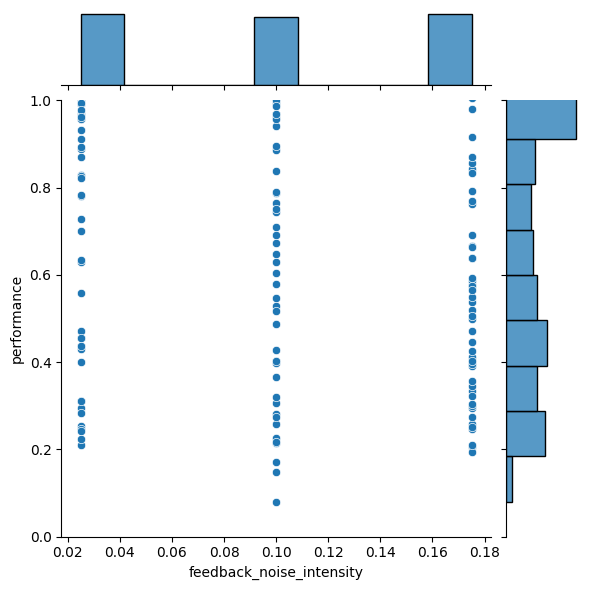

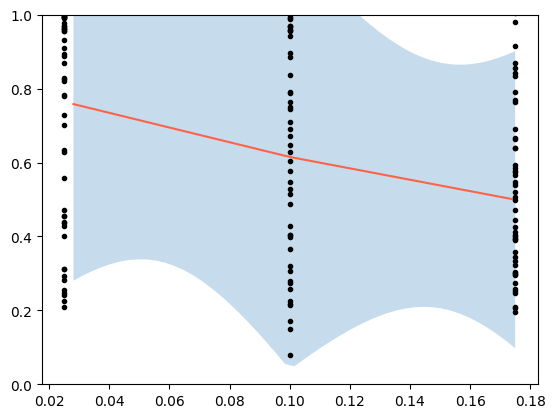

In [16]:
# Raw data :
g = sns.jointplot(data=subjects_df,x="feedback_noise_intensity", y="performance",ylim = (0,1))
x_limits = g.ax_joint.get_xlim()
y_limits = g.ax_joint.get_ylim()

# Get general tendencies + rough fitting :
# LOESS + bootstrapping (see https://james-brennan.github.io/posts/lowess_conf/)

from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
x,y = subjects_df["feedback_noise_intensity"],subjects_df["performance"]
sm_x, sm_y = sm_lowess(y, x,  frac=1./5., 
                           it=5, return_sorted = True).T

# # One lowess:
# fig,ax = plt.subplots(1)
# ax.plot(sm_x, sm_y, color='tomato')
# ax.plot(x, y, 'k.')

import scipy.interpolate

def smooth(x, y, xgrid,percent=50):
    samples = np.random.choice(len(x), int(len(x)*percent/100.0), replace=False)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s,x_s, frac=1./5., it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

xgrid = np.linspace(x.min(),x.max())
K = 100
smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T

# # K bootstrapped lowess
# fig,ax = plt.subplots(1)
# ax.plot(xgrid, smooths, color='tomato', alpha=0.25)
# ax.plot(x, y, 'k.')
# fig.show()

# Plot with 95% confidence interval (assuming gaussian dist) !
mean = np.nanmean(smooths, axis=1)
stderr = scipy.stats.sem(smooths, axis=1)
stderr = np.nanstd(smooths, axis=1, ddof=0)
# plot it
fig,ax = plt.subplots(1)
ax.fill_between(xgrid, mean-1.96*stderr,
                     mean+1.96*stderr, alpha=0.25)
ax.plot(xgrid, mean, color='tomato')
ax.plot(x, y, 'k.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
fig.show()

The results here are quite surpsing, it seems that the intensity of the feedback variations had no real effect on the ability of the subjects to control the gauge, suggesting that other factors (relating to subject individual representations) may have played a crucial role in learning to control the gauge. 

It seems that in this task, the performance of our subjects follow a mixture of (half)gaussian model with two clusters of means ($\sim1.0$ (learners) and $\sim0.4$ (non-learners)). This follows a very non-linear "either you get it or you don't" type of reasoning, stemming from the pattern recognition of the subjects. 

However, let's also note the unusual design of the feedback noise : it consisted in a fixed frequency (1HZ) oscillating around an unbiasied value. The maximum difference value was given by the intensity parameter (where 0.0 is no oscillation at all and 1.0 is the oscillation may cover the whole gauge). This value is not really enough to correctly qualify the effect of noise : we have to look at individual trials feedback values. Thankfully, we have recorded them ! 

## Real time feedback

Let's extract the real time feedback curves and get the evolution of the feedback in the time that followed each action (don't forget to account for prompts).

Noise intensity : 0.03
0.4511471386668523
0.5889986085440142
0.3053939715735054
0.596857425090275
0.3280313746166283
0.4941167606535537
0.7125961710216782
0.7413206057379295
0.2842054580923533
0.4692969027670024


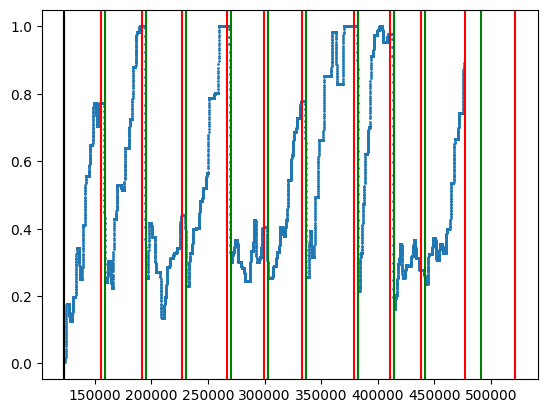

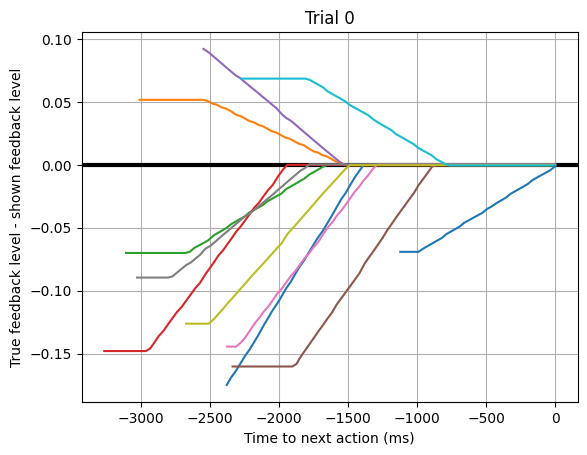

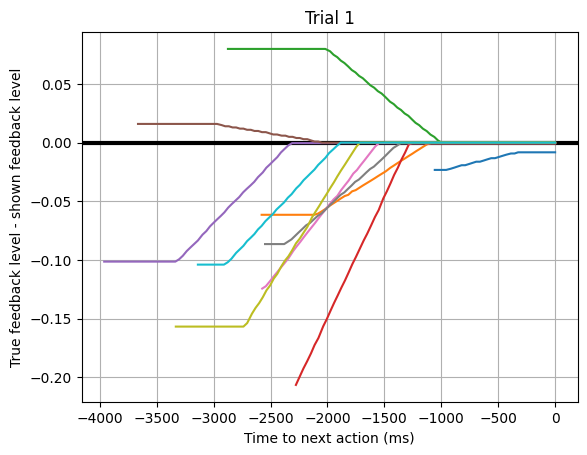

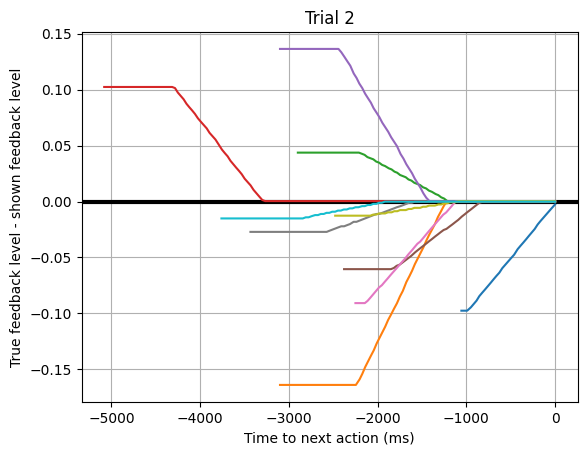

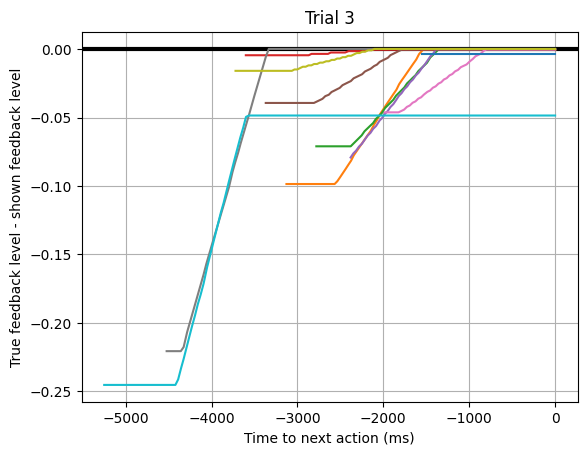

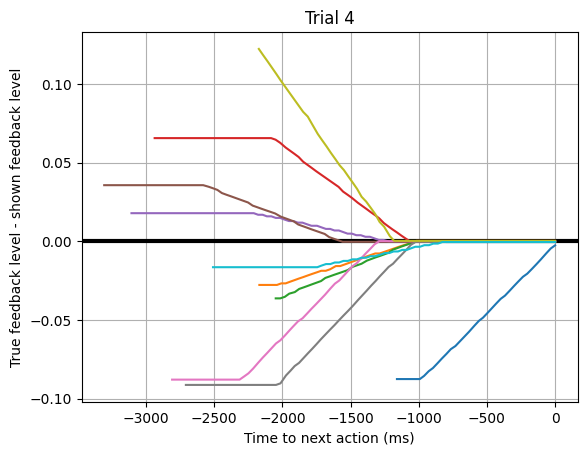

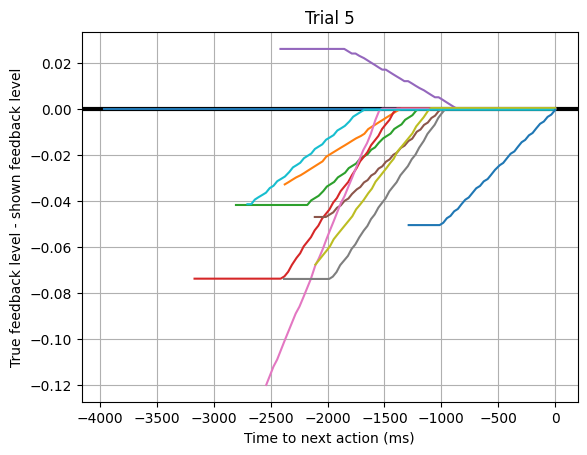

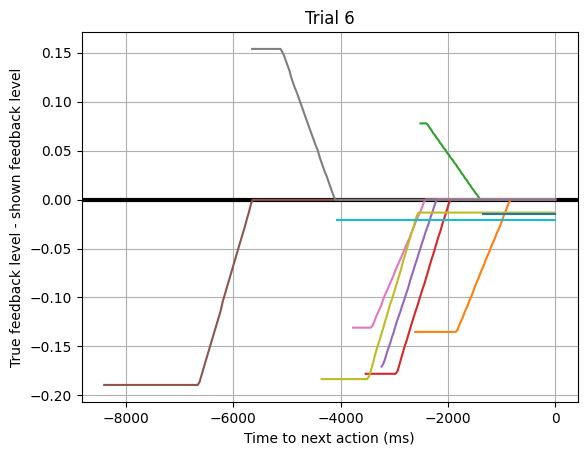

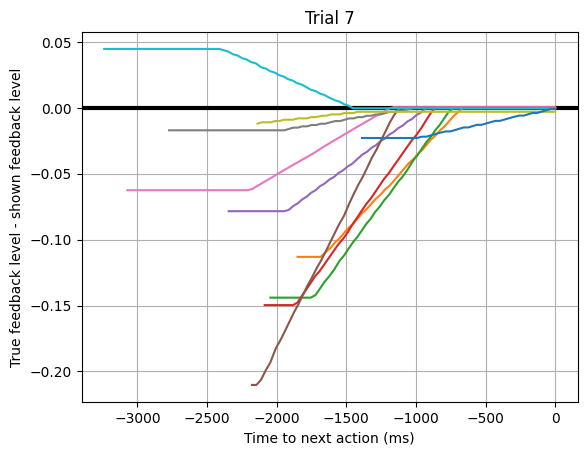

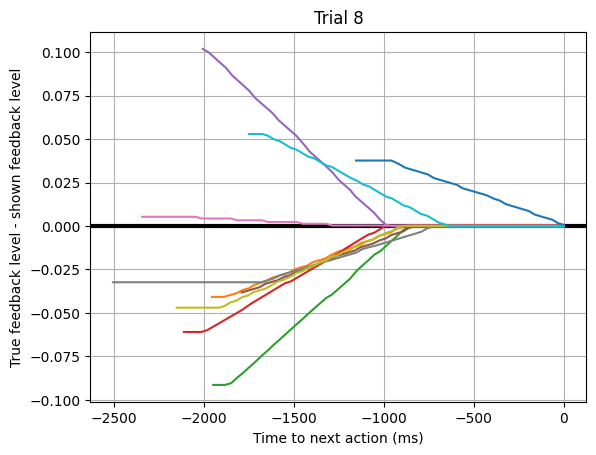

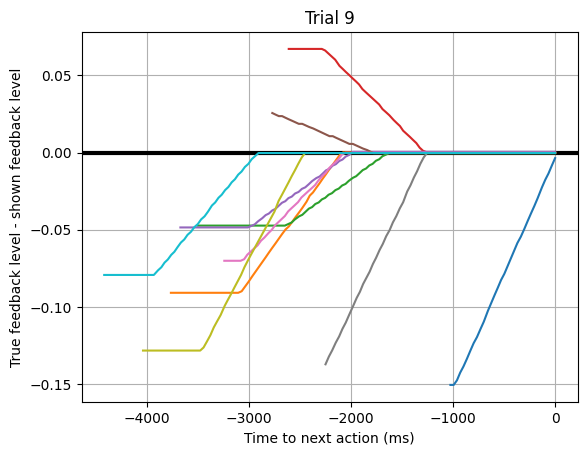

In [17]:
def get_values_in_interval(sorted_array,lower_bound=None,upper_bound=None,axis_searched=0):
    sort_axis = sorted_array[:,axis_searched]
    
    if lower_bound == None:
        lower_bound = np.min(sort_axis)
    if upper_bound == None:
        upper_bound = np.max(sort_axis)
    
    condition = (sort_axis>=lower_bound) & (sort_axis<=upper_bound)

    return sorted_array[condition]

# We're also interested in the trial timing data, to know precisely when an action was conducted, and when the gauge started moving :
TRIAL_DATA = [entry[2] for entry in TASK_RESULTS]
RT_FBS = [entry[3] for entry in TASK_RESULTS]
EVENTS = [entry[1] for entry in TASK_RESULTS]

i = 50

subject_i_features = subjects_df.iloc[i]
# print(subject_i_features)
print("Noise intensity : {:.2f}".format(subject_i_features["feedback_noise_intensity"]))
subject_i_fbs = RT_FBS[i]
subject_i_trial_data = TRIAL_DATA[i]

subject_i_timings = subject_i_trial_data["timing"]
subject_i_start_trial_tstamps = subject_i_timings["trial"]
subject_i_start_tstep_tstamps = subject_i_timings["timestep"]
subject_i_start_action_tstamps = subject_i_timings["action"]
misses_tracker = subject_i_timings["missed_actions"]


# Only keep the feedbacks recorded after the start of the trial : (and the initial timesteps within 2000 ms !)
true_first_trial_start_date = subject_i_start_trial_tstamps["start"][0]
task_start_t = true_first_trial_start_date - 2000  # Let's take a bit more leeway 
subject_i_start_trial_tstamps["start"][0] = task_start_t  
                # We change this value to use it when accounting for observed feedback values

# Remove the feedback values seen during the instructions :
subject_i_fbs = get_values_in_interval(subject_i_fbs,task_start_t)

# Subject feedback values for the whole training :
fig,ax = plt.subplots(1)
ax.scatter(subject_i_fbs[:,0],subject_i_fbs[:,1],s=1.0)
# ax.scatter(RT_FBS[i][:,0],RT_FBS[i][:,1],s=1.0,color="green")
for t in subject_i_start_trial_tstamps["start"]:
    ax.axvline(t,color="green")
for t in subject_i_start_trial_tstamps["end"]:
    ax.axvline(t,color="red")
ax.axvline(subject_i_start_tstep_tstamps["start"][0,0]-2000,color="black")
    
N_trials_visible = subject_i_start_trial_tstamps["start"].shape[0]-1 # last trial was blind !

# Get a plot for all trials side by side
# fig_all_trials,axs_all_trials = plt.subplots(1,N_trials_visible,sharey=True)
for trial_k in range(N_trials_visible):
    trial_start_t,trial_end_t = subject_i_start_trial_tstamps["start"][trial_k],subject_i_start_trial_tstamps["end"][trial_k]


    # Remove all data before this trial and all data after
    trial_lb = (trial_start_t if trial_k > 0 else None) # Take into account the initial gauge movement
    trial_feedbacks = get_values_in_interval(subject_i_fbs,trial_lb,trial_end_t)
    
    
    
    
    # Let's try to keep only the arrays we're interested in (we could probably do this with a dataframe...)
    
    
    # The initial observation is everything between the start of the trial and the very first action point
    observation_start_t,observation_end_t = trial_start_t,subject_i_start_action_tstamps["end"][trial_k,0]
    all_observation_arrays = [get_values_in_interval(trial_feedbacks,observation_start_t,observation_end_t)]
        
    
    Ntimesteps = subject_i_start_tstep_tstamps["start"].shape[-1]
    for timestep_k in range(1,Ntimesteps):
        observation_start_t,observation_end_t = subject_i_start_action_tstamps["end"][trial_k,timestep_k-1],subject_i_start_action_tstamps["end"][trial_k,timestep_k]
        if misses_tracker[trial_k,timestep_k]>0.51:
            # If we missed the action, the observation_end_t can be considered as the timestep end :
            observation_end_t = subject_i_start_tstep_tstamps["end"][trial_k,timestep_k]

        if (observation_end_t-observation_start_t> 1): # There was no further observations this trial : the subject already won !
            all_observation_arrays.append(get_values_in_interval(trial_feedbacks,observation_start_t,observation_end_t))    
    
    # The very last observation is between the last action and the end of the trial !
    last_obs_start_t = subject_i_start_action_tstamps["end"][trial_k,-1]
    last_obs_end_t = trial_end_t
    last_observations = get_values_in_interval(trial_feedbacks,last_obs_start_t,last_obs_end_t)
    if last_observations.shape[0]>0:
        all_observation_arrays.append(get_values_in_interval(trial_feedbacks,last_obs_start_t,last_obs_end_t))   
        
    # ____________________________________________________________________________________
    # OPTIONAL : PLOTS
    # ____________________________________________________________________________________
    # Get a plot for all trials side by side
    # ax = axs_all_trials[trial_k]
    # ax.scatter(trial_feedbacks[:,0],trial_feedbacks[:,1],s=1.0)
    
    # Plot this individual trial : 
    # fig,ax = plt.subplots(1)
    # ax.plot(trial_feedbacks[:,0],trial_feedbacks[:,2],lw=0.5,color="black")
    # ax.scatter(trial_feedbacks[:,0],trial_feedbacks[:,1],s=1.0)
    # Now, for each of the timesteps, let's plot the curve x points before and after the trial (excluding the prompts)
    # for trace in all_observation_arrays :
    #     ax.plot(trace[:,0],trace[:,1],color = np.random.random((3,)))
    # ax.set_xlabel("Task absolute time (ms)")
    # ax.set_ylabel("Shown feedback level")
    # ax.set_ylim([0.0,1.0])
    # ax.grid()
    # ax.set_title("Feedback noise intensity level = {:.2f}".format(subject_i_features["feedback_noise_intensity"]))
    # fig.suptitle("Subject " + str(subject_i_features["subject_id"]))
    # ____________________________________________________________________________________
        
    true_feedback_values = (subject_i_trial_data["scoring"]["feedback"][trial_k])
    print(np.mean(true_feedback_values))
    fig,ax = plt.subplots(1)
    ax.set_title("Trial {}".format(trial_k))
    ax.set_ylabel("True feedback level - shown feedback level")
    ax.set_xlabel("Time to next action (ms)")
    ax.grid()
    ax.axhline(0.0,lw=3.0,color="black")
    # For this trial, we want to measure the distance between the provided feedback and the true gauge level : 
    for tmstp_k,obs in enumerate(all_observation_arrays):
        norm_fb = obs[:,1] - true_feedback_values[tmstp_k]
        # norm_fb = obs[:,2] - obs[:,3]
        norm_time = obs[:,0] - np.max(obs[:,0])
        
        ax.plot(norm_time,norm_fb)

        # We want all the end points to be 0 (the time the action was taken)
 
# For 

## Transfer

Last trial : the 11th (and last) trial was done without a gauge. Let's compare its performance and the previous performances ! 

<Axes: xlabel='performance', ylabel='blind_trial_performance'>

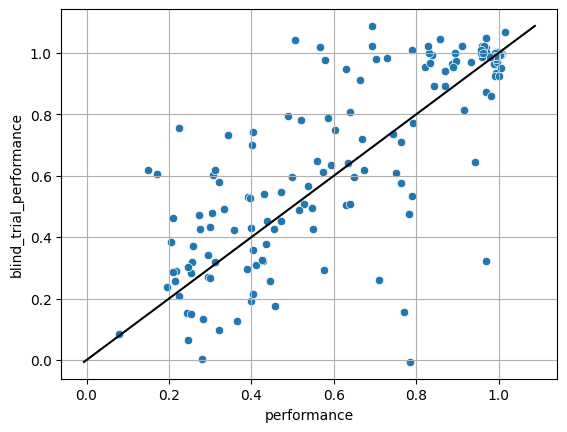

In [18]:

task_data = [subj_task_results[2] for subj_task_results in TASK_RESULTS] # Only get task data
feedback_for_all_subjects = np.stack([subj_data["scoring"]["feedback"] for subj_data in task_data])
last_trial_performance_metric = np.mean(feedback_for_all_subjects[:,-1,-last_t_timesteps:],axis=-1)
subjects_df["blind_trial_performance"] = last_trial_performance_metric.tolist()

fig,ax = plt.subplots(1)
linspace_perf_vals = np.linspace(np.min(last_trial_performance_metric),np.max(last_trial_performance_metric),1000)
ax.plot(linspace_perf_vals,linspace_perf_vals,color="black")
ax.grid()
sns.scatterplot(ax=ax,data = subjects_df,x="performance",y="blind_trial_performance")


There is clearly a positive correlation, seemingly well fit by a MoG model (K=2 clusters).

## More analysis ?

A more refined (subject-centered) modeling approach where the noise of the feedback is not the only predictor


Possible next steps : 
- Linear models (ANCOVA) of : performance ~ Age + Sex + TimeReadingInstr + NumberOfTestedActions ?
- More predictive models, to compare to usual Neurofeedback predictors :D
- More interesting variables : 
    - Time between feedback gauge update end & first action point
    - Ability to correctly predict the effect of ones' action
    - Employment / Student status + Number of Prolific tasks conducted previously
- Alternative feedback modality with no temporal mismatch between actions and gauge level 

## ANNEX : SUBJECT ANSWERS ON STRATEGY AND TASK DESIGN

In [ ]:
# Warning, the questions asked may vary based on the task ID !
print("According to you, what was the best strategy in order to control the gauge level ? In retrospect, what other strategy should you have attempted ? (Try to answer as precisely as possible.)")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["mandatory_q2"])
    # print("-> " + subject_dict["Nationality"])
print()
print("Did you notice any technical issues (buttons not working, graphical bugs, etc.) ? If yes, how did they appear ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q1"])
print() 
print("The instructions were meant to help you understand the task before it started. How clear did you find them ? What would you change to make them clearer ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q2"])
print() 
print("Do you think there was a logic behind how the gauge responded ? How hard / frustrating did you find the task ? Other remarks ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q3"])
print() 

According to you, what was the best strategy in order to control the gauge level ? In retrospect, what other strategy should you have attempted ? (Try to answer as precisely as possible.)
__________________________________________________________________________
-> 1st click on the bottom left corner, 2nd click on the top right corner
-> The strategy that i found was putting the points at the high level of the gray screen. I think the gauge level increases when the points are higher than the current level. I should have tried more what I mentioned last, because now that im thinking about it sometimes i didn't do it. In the beginning instead, i didnt understand at all how it worked. after a bunch of trials i figured out in order for it to be full my points should be higher. 
-> to start low and move higher each step
-> I tried to check all the spaces in the grey area. 
After that, I tried to notice when the gauge level went up accordingly to where I clicked.
If it went up, I repeat thos